# Top 5 Quotes dummy model

In [1]:
import pandas as pd
import itertools
import re
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import string
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

2022-03-03 13:55:26.416793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-03 13:55:26.417512: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
file = "../raw_data/quotes - reduced.csv"
quotes = pd.read_csv(file, decimal=",")
quotes.head(3)

,quote,author,category
0,"I'm selfish, impatient and a little insecure. ...",Marilyn Monroe,"attributed-no-source, best, life, love, mistak..."
1,You've gotta dance like there's nobody watchin...,William W. Purkey,"dance, heaven, hurt, inspirational, life, love..."
2,You know you're in love when you can't fall as...,Dr. Seuss,"attributed-no-source, dreams, love, reality, s..."


In [3]:
tags_list = quotes.category.to_list()
number_of_tags = []
for i in tags_list:
    number_of_tags.append(len(str(i).split(',')))

In [4]:
quotes['quotes_length'] = quotes['quote'].copy()
for index, row in quotes.iterrows():
    quotes.loc[index, "quotes_length"] = len(str(row['quotes_length']).split(' '))

## Cleaning data: tags are all lowercase, '-' were replaced with ',', duplicates were removed

In [5]:
for index, row in quotes.iterrows():
    quotes.loc[index, "category"] = str(row['category']).lower().replace('-',', ')

In [6]:
quotes['list_tags'] = quotes['category'].copy()
for index,row in quotes.iterrows():
    quotes.loc[index, 'count_tags'] = len(str(row['list_tags']).split(','))
quotes.count_tags.describe()

count    154318.000000
mean          9.758272
std          15.418337
min           1.000000
25%           3.000000
50%           5.000000
75%          11.000000
max         568.000000
Name: count_tags, dtype: float64

In [7]:
for index,row in quotes.iterrows():
    quotes.at[index, 'list_tags'] = str(row['list_tags']).split(',')

In [8]:
for index,row in quotes.iterrows():
    quotes.at[index, 'list_tags'] = str(set(row['list_tags']))

In [9]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
quotes['list_tags'] = quotes['list_tags'].apply(remove_punctuations)

In [10]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english")
tags_vectorized = vectorizer.fit_transform(quotes['list_tags'])
dummy_tags = LatentDirichletAllocation(n_components=5)
lda_vectors = dummy_tags.fit_transform(tags_vectorized)

In [11]:
def print_topics(model, vectorizer):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-10 - 1:-1]])
        

print_topics(dummy_tags, vectorizer.fit(quotes['list_tags']))

Topic 0:
[('religion', 1370.5273923834975), ('humour', 1344.952333765986), ('war', 1227.206538303888), ('politics', 1225.5503331531606), ('children', 1151.9874349826614), ('christianity', 960.7833647308468), ('leadership', 875.0738360807519), ('funny', 796.5038548292805), ('family', 710.9577103555193), ('god', 483.78390293525075)]
Topic 1:
[('humor', 1727.8533359357564), ('music', 1156.1892917602484), ('relationships', 1072.6463230921213), ('psychology', 1009.3575728442161), ('love', 975.5086090562465), ('reality', 843.1077644731284), ('beauty', 828.7513871474674), ('inspiration', 752.9763376735883), ('life', 570.7237936463284), ('freedom', 434.38443213566933)]
Topic 2:
[('friendship', 1291.6073805497788), ('science', 1282.7865648280929), ('nature', 884.438871138888), ('marriage', 691.0933156971889), ('time', 657.6090684011766), ('life', 592.292809632764), ('dreams', 580.4799887957256), ('humanity', 494.87714311899475), ('change', 476.64276384455417), ('love', 472.03140297775116)]
Topi

In [12]:
lda_vectors[1]

array([0.05904291, 0.06140315, 0.05919814, 0.4406249 , 0.3797309 ])

In [13]:
quotes.head()

,quote,author,category,quotes_length,list_tags,count_tags
0,"I'm selfish, impatient and a little insecure. ...",Marilyn Monroe,"attributed, no, source, best, life, love, mist...",41,control mistakes out truth life of wors...,12.0
1,You've gotta dance like there's nobody watchin...,William W. Purkey,"dance, heaven, hurt, inspirational, life, love...",22,dance heaven life sing love inspirational...,7.0
2,You know you're in love when you can't fall as...,Dr. Seuss,"attributed, no, source, dreams, love, reality,...",18,dreams reality sleep source love attribut...,7.0
3,A friend is someone who knows all about you an...,Elbert Hubbard,"friend, friendship, knowledge, love",13,love friend knowledge friendship,4.0
4,Darkness cannot drive out darkness: only light...,"Martin Luther King Jr., A Testament of Hope: T...","darkness, drive, out, hate, inspirational, lig...",20,peace out light love drive inspirational...,8.0


In [14]:
quotes.iloc[-1] = ['A large crowd is assembled on an outdoor street scene , with toy balloons visible and a woman walking a pink bicyc', 'image','image','5','A large crowd is assembled on an outdoor street scene , with toy balloons visible and a woman walking a pink bicyc','1']

In [15]:
picture_vectorized = vectorizer.transform(quotes.iloc[-1])
lda_vectors_self = dummy_tags.transform(picture_vectorized)
for index,row in quotes.iterrows():
    quotes['topic'] = quotes.quote.copy()

In [16]:
for index,row in quotes.iterrows():
    quotes.at[index, 'topic'] = np.where(lda_vectors[index] == max(lda_vectors[index]))[0][0]

In [17]:
quotes.tail()

,quote,author,category,quotes_length,list_tags,count_tags,topic
154313,The harassed look is that of a desperately tir...,"Christopher Isherwood, A Single Man","dying, living",96,living dying,2.0,4
154314,…In this way that he sought to control the ver...,"Jesse Ball, The Curfew","life, living, mindfulness",39,mindfulness life living,3.0,4
154315,"No matter how we choose to live, we both die a...","Adam Silvera, They Both Die at the End","death, living",13,death living,2.0,4
154316,The goal that you hope you will one day arrive...,"Marcus Aurelius, The Essential Marcus Aurelius",living,239,living,1.0,4
154317,A large crowd is assembled on an outdoor stree...,image,image,5,A large crowd is assembled on an outdoor stree...,1,0


(array([29563.,     0., 26418.,     0.,     0., 21179.,     0., 28805.,
            0., 48353.]),
 array([0.0, 0.4, 0.8, 1.2000000000000002, 1.6, 2.0, 2.4000000000000004,
        2.8000000000000003, 3.2, 3.6, 4.0], dtype=object),
 <BarContainer object of 10 artists>)

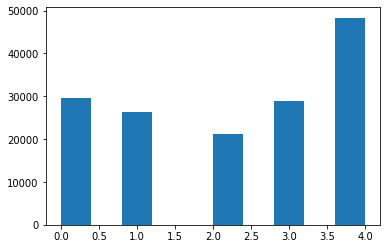

In [18]:
plt.hist(quotes.topic)

__Adding the image caption as the last line to our dataset to be able to see the closest neighbourhs__

In [19]:
image_topic = int(quotes.iloc[-1, [-1]])
image_topic

0

In [20]:
quotes = quotes.dropna()
only_topic = quotes[quotes.topic == image_topic]
only_topic.head()

,quote,author,category,quotes_length,list_tags,count_tags,topic
9,"The opposite of love is not hate, it's indiffe...",Elie Wiesel,"activism, apathy, hate, indifference, inspirat...",37,opposite indifference apathy philosophy l...,8.0,0
12,"Love all, trust a few, do wrong to none.","William Shakespeare, All's Well That Ends Well","do, wrong, love, trust, wrong",9,wrong love trust do,5.0,0
17,Love is that condition in which the happiness ...,"Robert A. Heinlein, Stranger in a Strange Land","essential, happiness, love",16,love happiness essential,3.0,0
34,"Dumbledore watched her fly away, and as her si...","J.K. Rowling, Harry Potter and the Deathly Hal...","dumbledore, life, love, snape",28,love snape life dumbledore,4.0,0
40,"Tis better to have loved and lost, Than never ...","Alfred Tennyson, In Memoriam","love, paraphrase, of, congreve",14,congreve paraphrase love of,4.0,0


In [21]:
tfidf_weight = vectorizer.fit_transform(only_topic['list_tags'].values.astype('U'))
nn_euc = NearestNeighbors(metric = 'euclidean')
nn_euc.fit(tfidf_weight)
image_index = -1
euc, indices = nn_euc.kneighbors(tfidf_weight[image_index], n_neighbors = 100)
neighbors_euc = pd.DataFrame({'euc': euc.flatten(), 'id': indices.flatten()})
result_top5 = (only_topic.merge(neighbors_euc, right_on = 'id', left_index = True).
                sort_values('euc')[['quote', 'author']]).head()

result_top5

,quote,author
36,Religion has actually convinced people that th...,George Carlin
62,Never say no when you really want to say yes.,"Jenny Han, Always and Forever, Lara Jean"
59,"Wrath held her even closer, right to his beati...","J.R. Ward, The King"
65,"I live a grateful life, and the result is pure...","Amy Leigh Mercree, Joyful Living: 101 Ways to ..."
16,Love yourself deeply and be satisfied with the...,"Amy Leigh Mercree, The Spiritual Girl's Guide ..."


In [22]:
most_suiting = quotes[quotes.topic != image_topic]
own_tags = input("Please give me 5 words that are descriptive of your picture:")
most_suiting.iloc[-1] = [own_tags,'image','image','5',own_tags,'1',image_topic]
most_suiting.tail()

Please give me 5 words that are descriptive of your picture:me, you


/tmp/ipykernel_8502/101407589.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_suiting.iloc[-1] = [own_tags,'image','image','5',own_tags,'1',image_topic]


,quote,author,category,quotes_length,list_tags,count_tags,topic
154312,Sasha's green eyes were right up against yours...,"Jennifer Egan, A Visit from the Goon Squad","coping, living, survival",77,survival coping living,3.0,4
154313,The harassed look is that of a desperately tir...,"Christopher Isherwood, A Single Man","dying, living",96,living dying,2.0,4
154314,…In this way that he sought to control the ver...,"Jesse Ball, The Curfew","life, living, mindfulness",39,mindfulness life living,3.0,4
154315,"No matter how we choose to live, we both die a...","Adam Silvera, They Both Die at the End","death, living",13,death living,2.0,4
154316,"me, you",image,image,5,"me, you",1,0


In [23]:
tfidf_weight = vectorizer.fit_transform(most_suiting['list_tags'].values.astype('U'))
nn_euc = NearestNeighbors(metric = 'euclidean')
nn_euc.fit(tfidf_weight)
image_index = -1
euc, indices = nn_euc.kneighbors(tfidf_weight[image_index], n_neighbors = 100)
neighbors_euc = pd.DataFrame({'euc': euc.flatten(), 'id': indices.flatten()})
result_most_s = (only_topic.merge(neighbors_euc, right_on = 'id', left_index = True).
                sort_values('euc')[['quote', 'author']]).head(1)

result_most_s.quote

5    Know that it is your birthright to awaken. See...
Name: quote, dtype: object

### Trying word2vec for the most suiting quote for better result

In [24]:
word2vec = Word2Vec(sentences=most_suiting.list_tags, vector_size=100, min_count=1, window=10)

In [ ]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed the training and test sentences
tags_embed = embedding(word2vec, most_suiting.list_tags)

# Pad the training and test embedded sentences
tags_pad = pad_sequences(tags_embed, dtype='float32', padding='post', maxlen=200)

In [ ]:
for X in most_suiting.list_tags:
    assert type(X) == np.ndarray
    assert X.shape[-1] == word2vec.wv.vector_size

assert tags_pad.shape[0] == len(most_suiting.list_tags)

In [ ]:
result = word2vec.most_similar(positive=[own_tags], topn=1)
result

### GridSearchCV for LDA finetuning (defining the number of components)

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lda', LatentDirichletAllocation()),
])



In [1]:
pipeline.get_params()

NameError: name 'pipeline' is not defined

In [ ]:
search_params = {'n_components': [5, 10, 20, 30], 'learning_decay': [.5, .7, .9]}
model = GridSearchCV(pipeline, param_grid=search_params, cv=5,)
model.fit(tags_vectorized)
6